## LOAD FORECASTING PROJECT 

In [121]:
import warnings
warnings.filterwarnings('ignore')

**Loading** **DATA**

In [122]:
import pandas as pd
df = pd.read_csv('continuous dataset.csv')

### Adding time based features 

In [123]:
df = df.set_index('Date_time')
df.index = pd.to_datetime(df.index, format='%d-%m-%Y %H:%M')

def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

### Visualize our Feature / Target Relationship

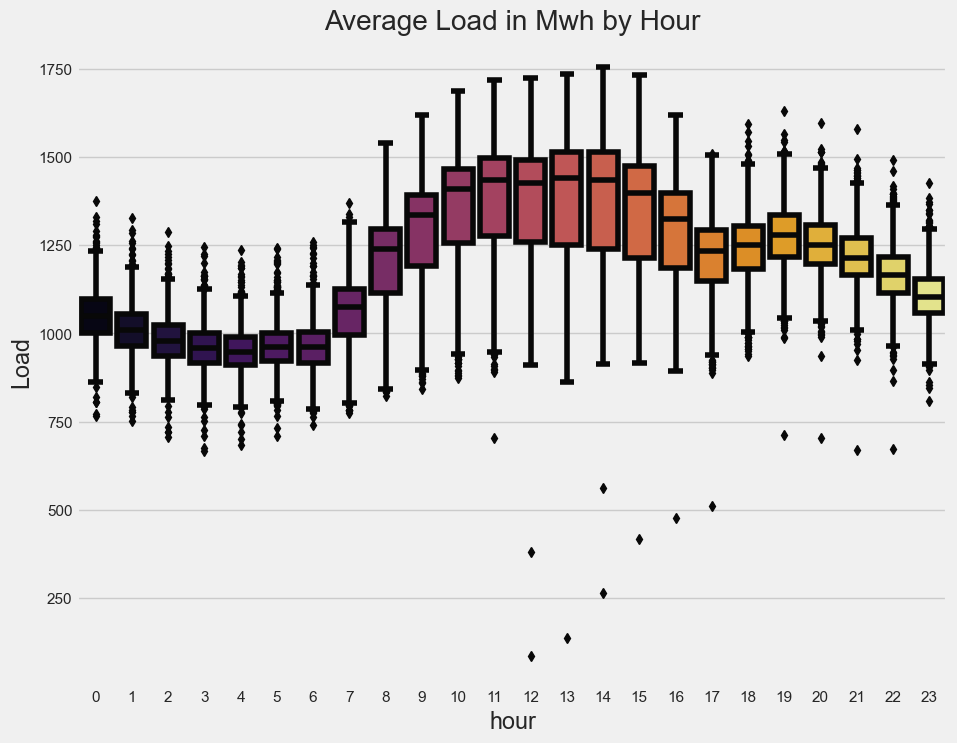

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns 
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df, x ='hour', y='Load', palette='inferno')
ax.set_title('Average Load in Mwh by Hour')
plt.show()

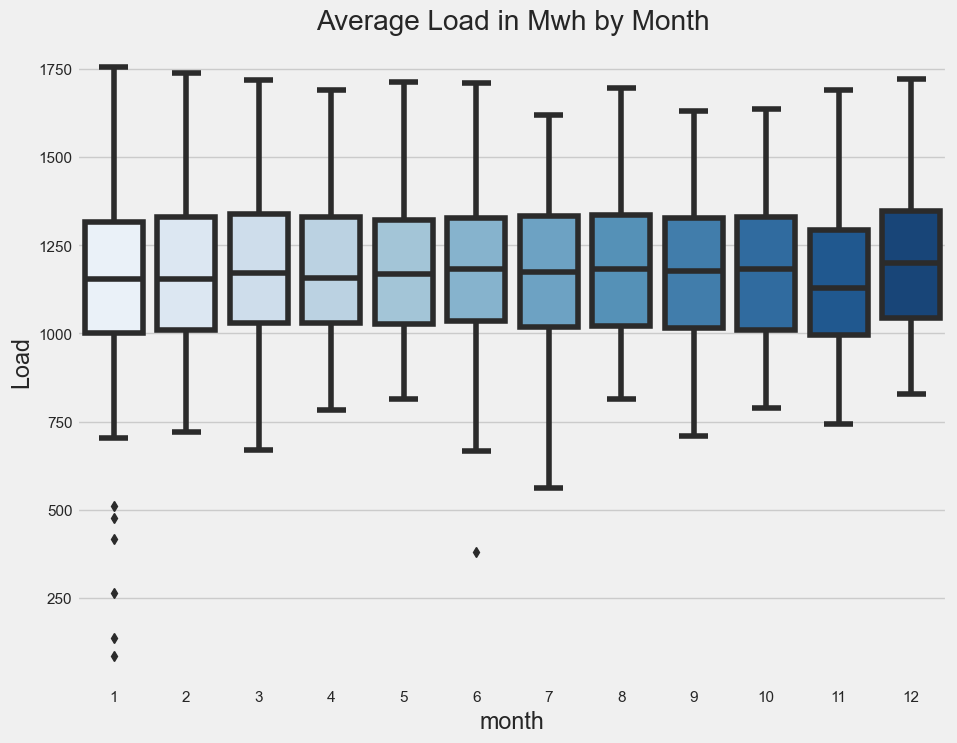

In [155]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df, x ='month', y='Load', palette='Blues')
ax.set_title('Average Load in Mwh by Month')
plt.show()

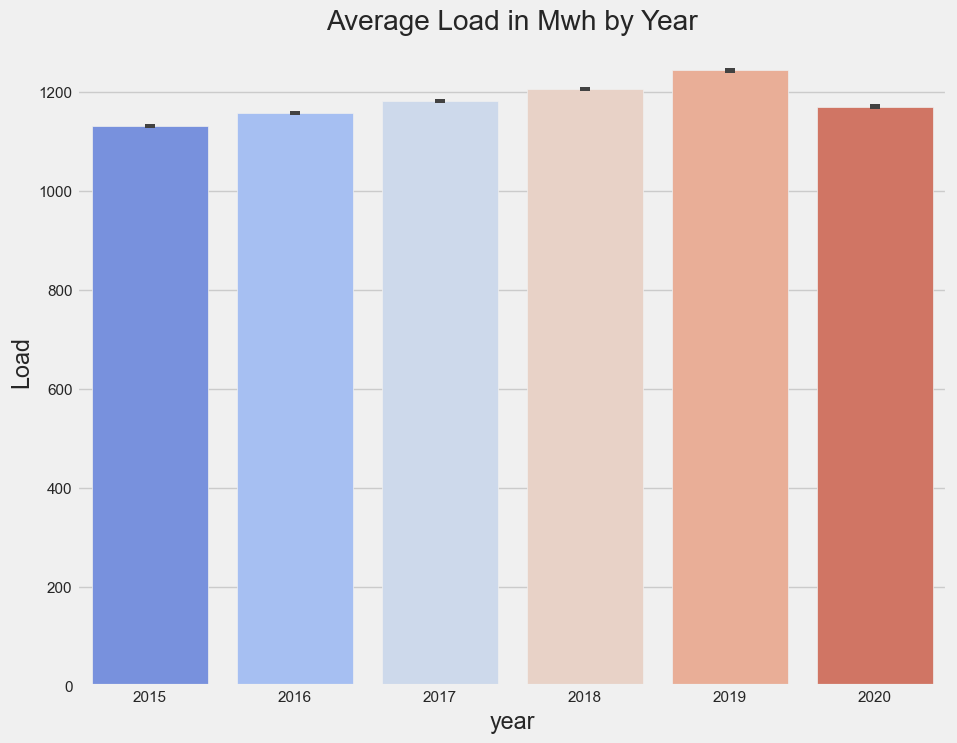

In [156]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data = df, x ='year', y='Load', palette='coolwarm')
ax.set_title('Average Load in Mwh by Year')
plt.show()

**Test-train Split**

In [127]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state =42)

**Generating Lagged Features and Rolling Statistics for Time Series Analysis**

In [128]:
windows = [12, 24, 128]
for column in train_df.columns:
    if column == 'Load':
        for window in windows:
            train_df[f"{column}_lag_{window}"] = train_df[column].shift(window)
            train_df[f"{column}_ma_mean{window}"] = train_df[column].rolling(window).mean()
            train_df[f"{column}_std_std{window}"] = train_df[column].rolling(window).std()
            train_df[f"{column}_ewm_std{window}"] = train_df[column].ewm(window).std()
            train_df[f"{column}_ewm_mean{window}"] = train_df[column].ewm(window).mean()


    if column != 'Date_time' and column != 'holiday' and column != 'school' and column != 'Holiday_ID' and column != 'Load':
        for window in windows:
            train_df[f"{column}_lag_{window}"] = train_df[column].shift(window)
            train_df[f"{column}_ma_mean{window}"] = train_df[column].rolling(window).mean()
            train_df[f"{column}_std_std{window}"] = train_df[column].rolling(window).std()
            train_df[f"{column}_ewm_std{window}"] = train_df[column].ewm(window).std()
            train_df[f"{column}_ewm_mean{window}"] = train_df[column].ewm(window).mean()
            train_df[f"{column}_min_max{window}"] = (train_df[column] -train_df[column].rolling(window).min()) / (train_df[column].rolling(window).max() - train_df[column].rolling(window).min())
            train_df[f"{column}_median{window}"] = train_df[column].rolling(window).median()
            train_df[f"{column}_skew{window}"] = train_df[column].rolling(window).skew()
            train_df[f"{column}_kurt{window}"] = train_df[column].rolling(window).kurt()
            train_df[f"{column}_p50{window}"] = train_df[column].rolling(window).quantile(0.5)

In [129]:
windows = [12, 24, 128]
for column in test_df.columns:
    if column == 'Load':
        for window in windows:
            test_df[f"{column}_lag_{window}"] = test_df[column].shift(window)
            test_df[f"{column}_ma_mean{window}"] = test_df[column].rolling(window).mean()
            test_df[f"{column}_std_std{window}"] = test_df[column].rolling(window).std()
            test_df[f"{column}_ewm_std{window}"] = test_df[column].ewm(window).std()
            test_df[f"{column}_ewm_mean{window}"] = test_df[column].ewm(window).mean()


    if column != 'Date_time' and column != 'holiday' and column != 'school' and column != 'Holiday_ID' and column != 'Load':
        for window in windows:
            test_df[f"{column}_lag_{window}"] = test_df[column].shift(window)
            test_df[f"{column}_ma_mean{window}"] = test_df[column].rolling(window).mean()
            test_df[f"{column}_std_std{window}"] = test_df[column].rolling(window).std()
            test_df[f"{column}_ewm_std{window}"] = test_df[column].ewm(window).std()
            test_df[f"{column}_ewm_mean{window}"] = test_df[column].ewm(window).mean()
            test_df[f"{column}_min_max{window}"] = (test_df[column] -test_df[column].rolling(window).min()) / (test_df[column].rolling(window).max() - test_df[column].rolling(window).min())
            test_df[f"{column}_median{window}"] = test_df[column].rolling(window).median()
            test_df[f"{column}_skew{window}"] = test_df[column].rolling(window).skew()
            test_df[f"{column}_kurt{window}"] = test_df[column].rolling(window).kurt()
            test_df[f"{column}_p50{window}"] = test_df[column].rolling(window).quantile(0.5)

**Removing Rows with Missing Values from Training and Testing DataFrames**

In [130]:
train_df.dropna(inplace = True)

In [131]:
test_df.dropna(inplace = True)

#### Performing test train split

In [132]:
X_train = train_df.drop(columns=['Load'])
X_test = test_df.drop(columns=['Load'])

In [133]:
y_train, y_test = train_df['Load'], test_df['Load']

#### Standardization {Scaling)

In [134]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### formation of d-matrix 

In [135]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=X_train.columns.tolist())
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=X_test.columns.tolist())

#### Defining objective function (xgboost)

In [136]:
from sklearn.metrics import mean_squared_error
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        'eta': trial.suggest_float('eta', 0.001, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'lambda': trial.suggest_float('lambda', 0.0, 2.0),
        'alpha': trial.suggest_float('alpha', 0.0, 2.0),
        'nthread': -1,
        'seed': 42
    }

    num_round = 100
    model = xgb.train(params, dtrain, num_round)

    predictions = model.predict(dtest)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

#### Performing hyperparameter tuning

In [137]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2024-08-21 13:40:39,315] A new study created in memory with name: no-name-ae582e21-7f5b-436a-919e-f96c9172ec9c
[I 2024-08-21 13:40:48,505] Trial 0 finished with value: 51.84311818962293 and parameters: {'eta': 0.4956604201665408, 'max_depth': 8, 'min_child_weight': 5.691242023088528, 'subsample': 0.6104727717007994, 'colsample_bytree': 0.9195166513370192, 'gamma': 1.5725617299257548, 'lambda': 1.4044831667414188, 'alpha': 0.2697330022905786}. Best is trial 0 with value: 51.84311818962293.
[I 2024-08-21 13:41:39,595] Trial 1 finished with value: 52.70990736120126 and parameters: {'eta': 0.4739626437573434, 'max_depth': 15, 'min_child_weight': 18.5320596036194, 'subsample': 0.6766978067086101, 'colsample_bytree': 0.5483816461206101, 'gamma': 1.564204420839896, 'lambda': 1.4240187270668232, 'alpha': 0.7306308495768445}. Best is trial 0 with value: 51.84311818962293.
[I 2024-08-21 13:42:42,065] Trial 2 finished with value: 44.924111372748214 and parameters: {'eta': 0.2753101795209097, '

In [138]:
best_params = study.best_params
best_params['tree_method'] = 'gpu_hist'
best_params['gpu_id'] = 0
print("Best params:", best_params)
xgb_best_params = best_params

Best params: {'eta': 0.10818254054538559, 'max_depth': 10, 'min_child_weight': 15.033002299154106, 'subsample': 0.9914861976307046, 'colsample_bytree': 0.9908378135820248, 'gamma': 2.2516087234592295, 'lambda': 0.0012206638890274735, 'alpha': 1.518174811962232, 'tree_method': 'gpu_hist', 'gpu_id': 0}


In [139]:
xgb_model = xgb.train(best_params, dtrain, 100)

In [140]:
predictions = xgb_model.predict(dtest)

#### Evaluation Scores

In [141]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, \
    max_error, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance, mean_absolute_percentage_error

rmse_test = mean_squared_error(y_test, predictions, squared=False)
mae_test = mean_absolute_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)
max_err = max_error(y_test, predictions)
poisson_deviance = mean_poisson_deviance(y_test, predictions)
gamma_deviance = mean_gamma_deviance(y_test, predictions)
tweedie_deviance = mean_tweedie_deviance(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"RMSE on test data: {rmse_test}")
print(f"MAE on test data: {mae_test}")
print("Mean Absolute Percentage Error:", mape)
print(f"R-squared on test data: {r2_test}")
print(f"Explained Variance on test data: {explained_variance}")
print(f"Max Error on test data: {max_err}")
print(f"Mean Poisson Deviance on test data: {poisson_deviance}")
print(f"Mean Gamma Deviance on test data: {gamma_deviance}")
print(f"Mean Tweedie Deviance on test data: {tweedie_deviance}")

RMSE on test data: 37.25701860420736
MAE on test data: 27.54490514771442
Mean Absolute Percentage Error: 0.024104848226019444
R-squared on test data: 0.962455504187253
Explained Variance on test data: 0.9624578633208408
Max Error on test data: 554.082835546875
Mean Poisson Deviance on test data: 1.2286160682074536
Mean Gamma Deviance on test data: 0.0011950195449283974
Mean Tweedie Deviance on test data: 1388.0854352742533


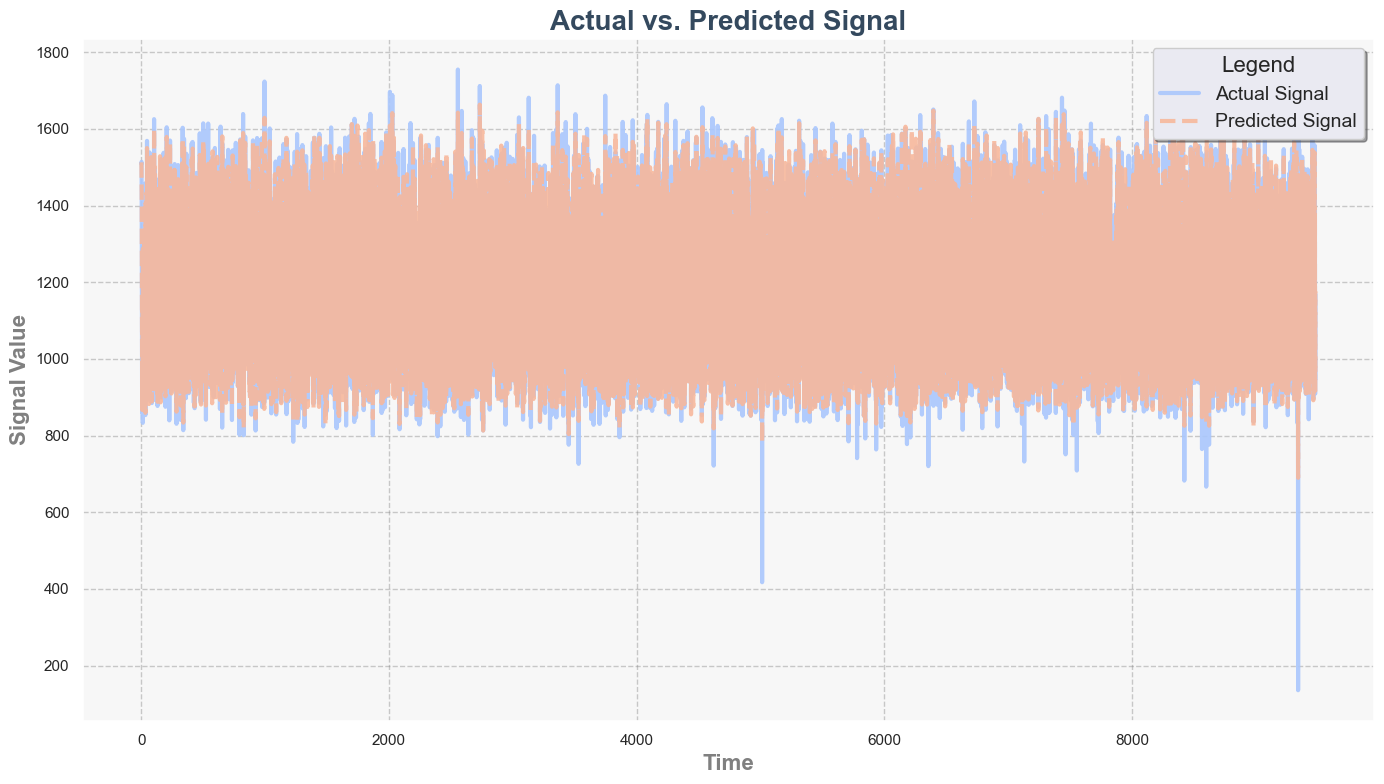

In [142]:
sns.set(style="darkgrid")
colors = sns.color_palette("coolwarm", 2)  # Cool-to-warm color gradient
plt.figure(figsize=(14, 8))
sns.lineplot(x=timestamps, y=y_test, label='Actual Signal', color=colors[0], linewidth=3, alpha=0.9)
sns.lineplot(x=timestamps, y=predictions, label='Predicted Signal', color=colors[1], linewidth=3, linestyle='--', alpha=0.9)
plt.xlabel('Time', fontsize=16, fontweight='bold', color='gray')
plt.ylabel('Signal Value', fontsize=16, fontweight='bold', color='gray')
plt.title('Actual vs. Predicted Signal', fontsize=20, fontweight='bold', color='#34495e')
plt.legend(loc='upper right', fontsize=14, title='Legend', title_fontsize='16', shadow=True)
plt.grid(True, linestyle='--', color='gray', alpha=0.4)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()


In [143]:
y_test_df , predictions_df

(                          Load
 Date_time                     
 2019-11-13 14:00:00  1509.0997
 2017-02-09 11:00:00  1514.0627
 2018-01-17 13:00:00  1407.1654
 2015-05-09 13:00:00  1268.4376
 2018-12-03 06:00:00  1021.1426
 ...                        ...
 2016-02-04 18:00:00  1228.9328
 2019-12-07 12:00:00  1392.0543
 2016-05-04 03:00:00   944.7045
 2020-03-24 15:00:00  1170.3642
 2015-11-30 02:00:00   909.8799
 
 [9482 rows x 1 columns],
                 0
 0     1517.640747
 1     1477.187988
 2     1412.943115
 3     1265.915161
 4      981.377197
 ...           ...
 9477  1223.596802
 9478  1399.360840
 9479   945.867126
 9480  1164.523193
 9481   907.121948
 
 [9482 rows x 1 columns])

#### Formation of lgb dataset

In [144]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

#### Defining Objective function (LightGBM)

In [148]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 4, 64),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'num_boost_round': 1000,
        'early_stopping_rounds': 50,
        'device': 'cpu',  # Use GPU for training

    }


    model = lgb.train(params, train_data, valid_sets=[test_data])

    predictions = model.predict(X_test_scaled)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

#### Hyperparameter tuning

In [149]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2024-08-21 14:40:29,485] A new study created in memory with name: no-name-1a18fce4-a51c-42d8-8406-c9a5b41b12c5


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:40:41,728] Trial 0 finished with value: 40.6448214956748 and parameters: {'num_leaves': 8, 'learning_rate': 0.07939811662335398, 'feature_fraction': 0.8519829673721215, 'bagging_fraction': 0.7436749169920103, 'bagging_freq': 3}. Best is trial 0 with value: 40.6448214956748.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 40.6448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:40:59,981] Trial 1 finished with value: 36.73403605617215 and parameters: {'num_leaves': 50, 'learning_rate': 0.06724894127139824, 'feature_fraction': 0.804837391281849, 'bagging_fraction': 0.9306278978922309, 'bagging_freq': 3}. Best is trial 1 with value: 36.73403605617215.


Early stopping, best iteration is:
[376]	valid_0's rmse: 36.734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:41:20,233] Trial 2 finished with value: 38.23244973474824 and parameters: {'num_leaves': 41, 'learning_rate': 0.08025417376257006, 'feature_fraction': 0.9259350780480187, 'bagging_fraction': 0.5635372031430337, 'bagging_freq': 9}. Best is trial 1 with value: 36.73403605617215.


Early stopping, best iteration is:
[395]	valid_0's rmse: 38.2324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 42.156


[I 2024-08-21 14:42:06,187] Trial 3 finished with value: 42.15595110526395 and parameters: {'num_leaves': 47, 'learning_rate': 0.005375671769572819, 'feature_fraction': 0.6517156044490625, 'bagging_fraction': 0.6994196809732247, 'bagging_freq': 5}. Best is trial 1 with value: 36.73403605617215.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:42:15,437] Trial 4 finished with value: 40.846294536828864 and parameters: {'num_leaves': 9, 'learning_rate': 0.06417550568040459, 'feature_fraction': 0.6882046364502277, 'bagging_fraction': 0.6040769972890183, 'bagging_freq': 2}. Best is trial 1 with value: 36.73403605617215.


Did not meet early stopping. Best iteration is:
[978]	valid_0's rmse: 40.8463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 37.5367


[I 2024-08-21 14:43:26,243] Trial 5 finished with value: 37.536692880702056 and parameters: {'num_leaves': 47, 'learning_rate': 0.011601027440865393, 'feature_fraction': 0.8796133211402801, 'bagging_fraction': 0.849951840141322, 'bagging_freq': 1}. Best is trial 1 with value: 36.73403605617215.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:43:39,924] Trial 6 finished with value: 37.80513320119565 and parameters: {'num_leaves': 42, 'learning_rate': 0.07044471477248522, 'feature_fraction': 0.5463837489384462, 'bagging_fraction': 0.7807054991055392, 'bagging_freq': 7}. Best is trial 1 with value: 36.73403605617215.


Early stopping, best iteration is:
[390]	valid_0's rmse: 37.8051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:43:57,140] Trial 7 finished with value: 39.51641038006626 and parameters: {'num_leaves': 19, 'learning_rate': 0.024051819403098106, 'feature_fraction': 0.5608521669507998, 'bagging_fraction': 0.8874780738127268, 'bagging_freq': 9}. Best is trial 1 with value: 36.73403605617215.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 39.5164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:44:11,099] Trial 8 finished with value: 37.719819404598866 and parameters: {'num_leaves': 59, 'learning_rate': 0.0892822694014283, 'feature_fraction': 0.8569365621289855, 'bagging_fraction': 0.678165427694808, 'bagging_freq': 3}. Best is trial 1 with value: 36.73403605617215.


Early stopping, best iteration is:
[182]	valid_0's rmse: 37.7198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[833]	valid_0's rmse: 38.3885


[I 2024-08-21 14:44:36,110] Trial 9 finished with value: 38.388480059642376 and parameters: {'num_leaves': 42, 'learning_rate': 0.029166169607936367, 'feature_fraction': 0.6127250831313539, 'bagging_fraction': 0.5021166515723829, 'bagging_freq': 10}. Best is trial 1 with value: 36.73403605617215.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:45:26,895] Trial 10 finished with value: 35.68597343736336 and parameters: {'num_leaves': 62, 'learning_rate': 0.04737965972732919, 'feature_fraction': 0.9988352743071618, 'bagging_fraction': 0.9931947904457974, 'bagging_freq': 5}. Best is trial 10 with value: 35.68597343736336.


Early stopping, best iteration is:
[601]	valid_0's rmse: 35.686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:46:16,296] Trial 11 finished with value: 35.41174336337454 and parameters: {'num_leaves': 61, 'learning_rate': 0.04472022743713934, 'feature_fraction': 0.7646174666044027, 'bagging_fraction': 0.9968796855742372, 'bagging_freq': 5}. Best is trial 11 with value: 35.41174336337454.


Early stopping, best iteration is:
[823]	valid_0's rmse: 35.4117
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[780]	valid_0's rmse: 35.5776


[I 2024-08-21 14:47:18,203] Trial 12 finished with value: 35.5775623803085 and parameters: {'num_leaves': 61, 'learning_rate': 0.04551627450142921, 'feature_fraction': 0.9941143672134944, 'bagging_fraction': 0.9866162739793358, 'bagging_freq': 6}. Best is trial 11 with value: 35.41174336337454.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:47:46,331] Trial 13 finished with value: 37.339379092001856 and parameters: {'num_leaves': 28, 'learning_rate': 0.04673201005588691, 'feature_fraction': 0.7623559297480238, 'bagging_fraction': 0.9968512427758652, 'bagging_freq': 7}. Best is trial 11 with value: 35.41174336337454.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 37.3394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[848]	valid_0's rmse: 35.8099


[I 2024-08-21 14:48:55,709] Trial 14 finished with value: 35.80985562417419 and parameters: {'num_leaves': 64, 'learning_rate': 0.03506104666328632, 'feature_fraction': 0.997685384417726, 'bagging_fraction': 0.9256149436139611, 'bagging_freq': 6}. Best is trial 11 with value: 35.41174336337454.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:49:27,690] Trial 15 finished with value: 36.765374513087295 and parameters: {'num_leaves': 54, 'learning_rate': 0.05738743887681247, 'feature_fraction': 0.9313161266185532, 'bagging_fraction': 0.8156345666324494, 'bagging_freq': 6}. Best is trial 11 with value: 35.41174336337454.


Early stopping, best iteration is:
[501]	valid_0's rmse: 36.7654
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 37.1531


[I 2024-08-21 14:49:57,459] Trial 16 finished with value: 37.15309791420705 and parameters: {'num_leaves': 32, 'learning_rate': 0.041005599892180736, 'feature_fraction': 0.7282223945503001, 'bagging_fraction': 0.9348323699542014, 'bagging_freq': 4}. Best is trial 11 with value: 35.41174336337454.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 36.228


[I 2024-08-21 14:50:54,792] Trial 17 finished with value: 36.22804486093564 and parameters: {'num_leaves': 57, 'learning_rate': 0.01823945305949154, 'feature_fraction': 0.77136157541953, 'bagging_fraction': 0.8685870959241985, 'bagging_freq': 7}. Best is trial 11 with value: 35.41174336337454.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:51:25,280] Trial 18 finished with value: 37.73724783577227 and parameters: {'num_leaves': 23, 'learning_rate': 0.05717567058827246, 'feature_fraction': 0.9382403429673406, 'bagging_fraction': 0.9619412277108967, 'bagging_freq': 8}. Best is trial 11 with value: 35.41174336337454.


Did not meet early stopping. Best iteration is:
[977]	valid_0's rmse: 37.7372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632
Training until validation scores don't improve for 50 rounds


[I 2024-08-21 14:51:43,932] Trial 19 finished with value: 36.52886914332895 and parameters: {'num_leaves': 53, 'learning_rate': 0.09985017497124073, 'feature_fraction': 0.8062209296002487, 'bagging_fraction': 0.8899727809768734, 'bagging_freq': 4}. Best is trial 11 with value: 35.41174336337454.


Early stopping, best iteration is:
[342]	valid_0's rmse: 36.5289


In [157]:
best_params = study.best_params
lgb_best_params = best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_leaves': 61, 'learning_rate': 0.04472022743713934, 'feature_fraction': 0.7646174666044027, 'bagging_fraction': 0.9968796855742372, 'bagging_freq': 5}


In [158]:
lgb_model = lgb.train(best_params, train_data, valid_sets=[test_data])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128372
[LightGBM] [Info] Number of data points in the train set: 38310, number of used features: 576
[LightGBM] [Info] Start training from score 1183.328632


#### Evaluation scores

In [159]:
predictions = lgb_model.predict(X_test_scaled)

rmse_test = mean_squared_error(y_test, predictions, squared=False)
mae_test = mean_absolute_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)
max_err = max_error(y_test, predictions)
poisson_deviance = mean_poisson_deviance(y_test, predictions)
gamma_deviance = mean_gamma_deviance(y_test, predictions)
tweedie_deviance = mean_tweedie_deviance(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"RMSE on test data: {rmse_test}")
print(f"MAE on test data: {mae_test}")
print("Mean Absolute Percentage Error:", mape)
print(f"R-squared on test data: {r2_test}")
print(f"Explained Variance on test data: {explained_variance}")
print(f"Max Error on test data: {max_err}")
print(f"Mean Poisson Deviance on test data: {poisson_deviance}")
print(f"Mean Gamma Deviance on test data: {gamma_deviance}")
print(f"Mean Tweedie Deviance on test data: {tweedie_deviance}")

RMSE on test data: 42.79600078822947
MAE on test data: 31.99469635520794
Mean Absolute Percentage Error: 0.028208253683551815
R-squared on test data: 0.95046222994598
Explained Variance on test data: 0.9504632184935141
Max Error on test data: 707.4622832910261
Mean Poisson Deviance on test data: 1.6253427205056041
Mean Gamma Deviance on test data: 0.001563762564574085
Mean Tweedie Deviance on test data: 1831.4976834661372


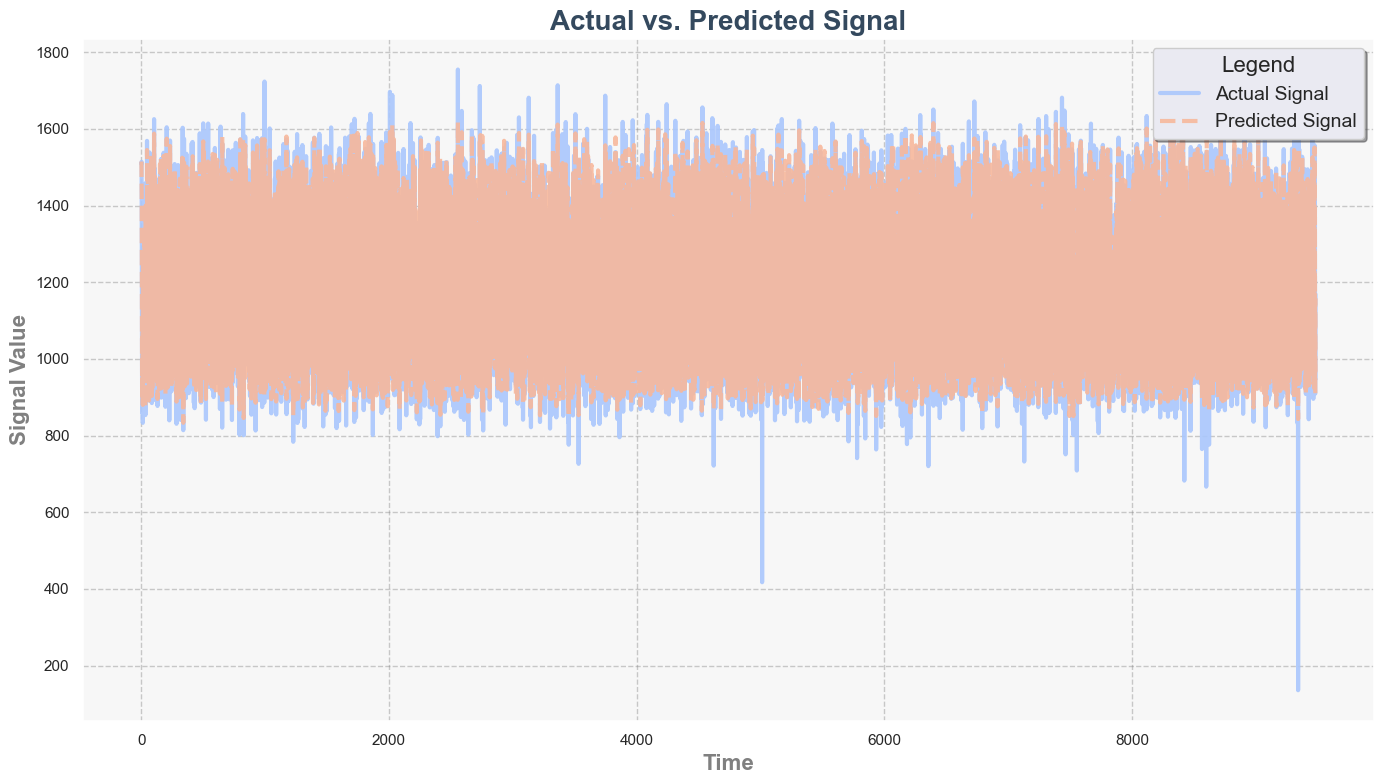

In [160]:
sns.set(style="darkgrid")
colors = sns.color_palette("coolwarm", 2)  # Cool-to-warm color gradient
plt.figure(figsize=(14, 8))
sns.lineplot(x=timestamps, y=y_test, label='Actual Signal', color=colors[0], linewidth=3, alpha=0.9)
sns.lineplot(x=timestamps, y=predictions, label='Predicted Signal', color=colors[1], linewidth=3, linestyle='--', alpha=0.9)
plt.xlabel('Time', fontsize=16, fontweight='bold', color='gray')
plt.ylabel('Signal Value', fontsize=16, fontweight='bold', color='gray')
plt.title('Actual vs. Predicted Signal', fontsize=20, fontweight='bold', color='#34495e')
plt.legend(loc='upper right', fontsize=14, title='Legend', title_fontsize='16', shadow=True)
plt.grid(True, linestyle='--', color='gray', alpha=0.4)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()

In [161]:
y_test_df , predictions_df

(                          Load
 Date_time                     
 2019-11-13 14:00:00  1509.0997
 2017-02-09 11:00:00  1514.0627
 2018-01-17 13:00:00  1407.1654
 2015-05-09 13:00:00  1268.4376
 2018-12-03 06:00:00  1021.1426
 ...                        ...
 2016-02-04 18:00:00  1228.9328
 2019-12-07 12:00:00  1392.0543
 2016-05-04 03:00:00   944.7045
 2020-03-24 15:00:00  1170.3642
 2015-11-30 02:00:00   909.8799
 
 [9482 rows x 1 columns],
                 0
 0     1517.640747
 1     1477.187988
 2     1412.943115
 3     1265.915161
 4      981.377197
 ...           ...
 9477  1223.596802
 9478  1399.360840
 9479   945.867126
 9480  1164.523193
 9481   907.121948
 
 [9482 rows x 1 columns])

#### Linear Regression 

In [162]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled,y_train)

LinearRegression()

#### Evalution scores

In [163]:
y_pred = model.predict(X_test_scaled)

rmse_test = mean_squared_error(y_test, y_pred, squared=False)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)
max_err = max_error(y_test, y_pred)
poisson_deviance = mean_poisson_deviance(y_test, y_pred)
gamma_deviance = mean_gamma_deviance(y_test, y_pred)
tweedie_deviance = mean_tweedie_deviance(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE on test data: {rmse_test}")
print(f"MAE on test data: {mae_test}")
print("Mean Absolute Percentage Error:", mape)
print(f"R-squared on test data: {r2_test}")
print(f"Explained Variance on test data: {explained_variance}")
print(f"Max Error on test data: {max_err}")
print(f"Mean Poisson Deviance on test data: {poisson_deviance}")
print(f"Mean Gamma Deviance on test data: {gamma_deviance}")
print(f"Mean Tweedie Deviance on test data: {tweedie_deviance}")

RMSE on test data: 97.90885207248925
MAE on test data: 77.66883674761294
Mean Absolute Percentage Error: 0.06783801586814951
R-squared on test data: 0.7407170276608477
Explained Variance on test data: 0.740757149633291
Max Error on test data: 813.0103444789272
Mean Poisson Deviance on test data: 8.25460328516557
Mean Gamma Deviance on test data: 0.007356973032259248
Mean Tweedie Deviance on test data: 9586.143314152583


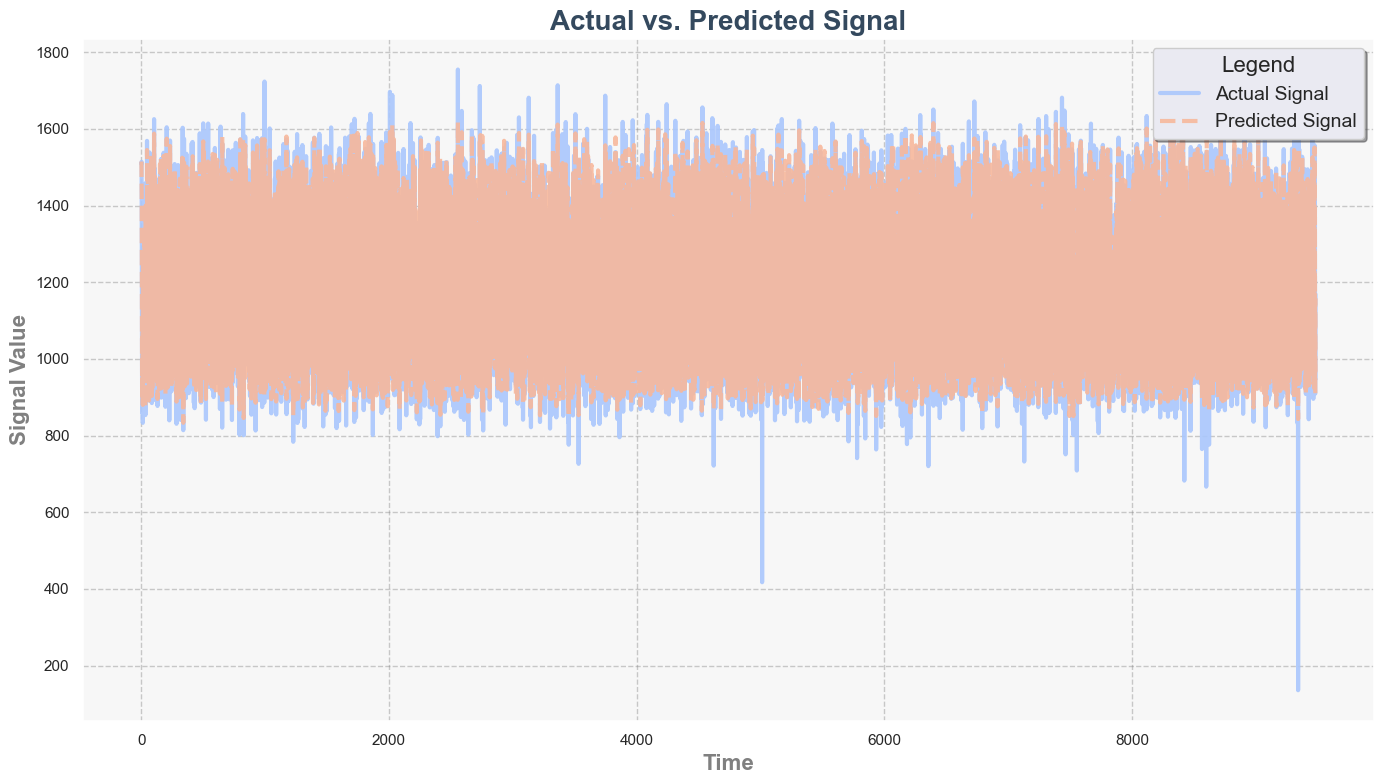

In [164]:
sns.set(style="darkgrid")
colors = sns.color_palette("coolwarm", 2)  # Cool-to-warm color gradient
plt.figure(figsize=(14, 8))
sns.lineplot(x=timestamps, y=y_test, label='Actual Signal', color=colors[0], linewidth=3, alpha=0.9)
sns.lineplot(x=timestamps, y=predictions, label='Predicted Signal', color=colors[1], linewidth=3, linestyle='--', alpha=0.9)
plt.xlabel('Time', fontsize=16, fontweight='bold', color='gray')
plt.ylabel('Signal Value', fontsize=16, fontweight='bold', color='gray')
plt.title('Actual vs. Predicted Signal', fontsize=20, fontweight='bold', color='#34495e')
plt.legend(loc='upper right', fontsize=14, title='Legend', title_fontsize='16', shadow=True)
plt.grid(True, linestyle='--', color='gray', alpha=0.4)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()

In [165]:
y_test_df , predictions_df

(                          Load
 Date_time                     
 2019-11-13 14:00:00  1509.0997
 2017-02-09 11:00:00  1514.0627
 2018-01-17 13:00:00  1407.1654
 2015-05-09 13:00:00  1268.4376
 2018-12-03 06:00:00  1021.1426
 ...                        ...
 2016-02-04 18:00:00  1228.9328
 2019-12-07 12:00:00  1392.0543
 2016-05-04 03:00:00   944.7045
 2020-03-24 15:00:00  1170.3642
 2015-11-30 02:00:00   909.8799
 
 [9482 rows x 1 columns],
                 0
 0     1517.640747
 1     1477.187988
 2     1412.943115
 3     1265.915161
 4      981.377197
 ...           ...
 9477  1223.596802
 9478  1399.360840
 9479   945.867126
 9480  1164.523193
 9481   907.121948
 
 [9482 rows x 1 columns])

#### LassoRegression

In [166]:
from sklearn.linear_model import LassoCV
model = LassoCV()
model.fit(X_train_scaled,y_train)

LassoCV()

#### Evaluation Scores

In [167]:
y_pred = model.predict(X_test_scaled)

rmse_test = mean_squared_error(y_test, y_pred, squared=False)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)
max_err = max_error(y_test, y_pred)
poisson_deviance = mean_poisson_deviance(y_test, y_pred)
gamma_deviance = mean_gamma_deviance(y_test, y_pred)
tweedie_deviance = mean_tweedie_deviance(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE on test data: {rmse_test}")
print(f"MAE on test data: {mae_test}")
print("Mean Absolute Percentage Error:", mape)
print(f"R-squared on test data: {r2_test}")
print(f"Explained Variance on test data: {explained_variance}")
print(f"Max Error on test data: {max_err}")
print(f"Mean Poisson Deviance on test data: {poisson_deviance}")
print(f"Mean Gamma Deviance on test data: {gamma_deviance}")
print(f"Mean Tweedie Deviance on test data: {tweedie_deviance}")

RMSE on test data: 94.38603380616749
MAE on test data: 74.23389104091528
Mean Absolute Percentage Error: 0.0647739835742177
R-squared on test data: 0.7590396678405064
Explained Variance on test data: 0.7590544832296406
Max Error on test data: 891.8225978547682
Mean Poisson Deviance on test data: 7.593520227413465
Mean Gamma Deviance on test data: 0.006692414491672743
Mean Tweedie Deviance on test data: 8908.723377658991


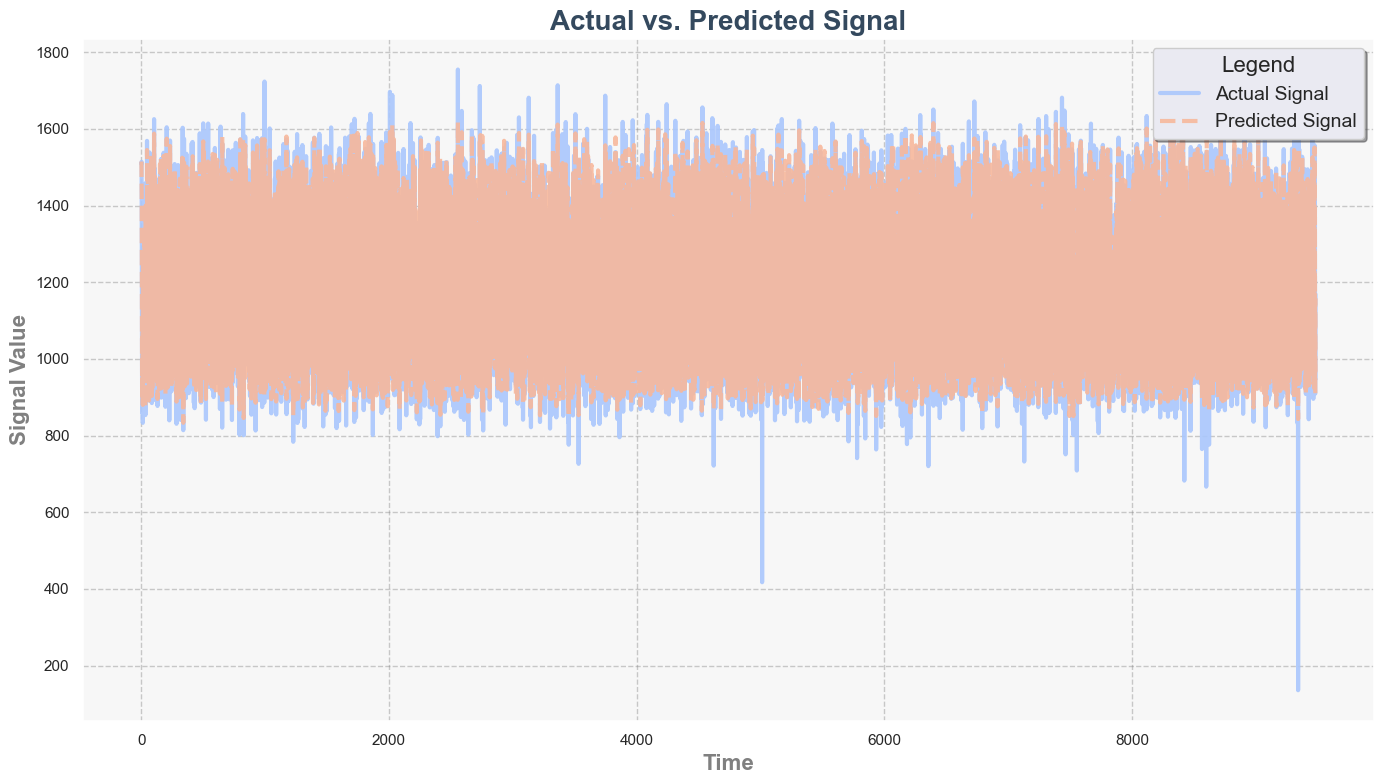

In [168]:
sns.set(style="darkgrid")
colors = sns.color_palette("coolwarm", 2)  # Cool-to-warm color gradient
plt.figure(figsize=(14, 8))
sns.lineplot(x=timestamps, y=y_test, label='Actual Signal', color=colors[0], linewidth=3, alpha=0.9)
sns.lineplot(x=timestamps, y=predictions, label='Predicted Signal', color=colors[1], linewidth=3, linestyle='--', alpha=0.9)
plt.xlabel('Time', fontsize=16, fontweight='bold', color='gray')
plt.ylabel('Signal Value', fontsize=16, fontweight='bold', color='gray')
plt.title('Actual vs. Predicted Signal', fontsize=20, fontweight='bold', color='#34495e')
plt.legend(loc='upper right', fontsize=14, title='Legend', title_fontsize='16', shadow=True)
plt.grid(True, linestyle='--', color='gray', alpha=0.4)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()

In [169]:
y_test_df , predictions_df

(                          Load
 Date_time                     
 2019-11-13 14:00:00  1509.0997
 2017-02-09 11:00:00  1514.0627
 2018-01-17 13:00:00  1407.1654
 2015-05-09 13:00:00  1268.4376
 2018-12-03 06:00:00  1021.1426
 ...                        ...
 2016-02-04 18:00:00  1228.9328
 2019-12-07 12:00:00  1392.0543
 2016-05-04 03:00:00   944.7045
 2020-03-24 15:00:00  1170.3642
 2015-11-30 02:00:00   909.8799
 
 [9482 rows x 1 columns],
                 0
 0     1517.640747
 1     1477.187988
 2     1412.943115
 3     1265.915161
 4      981.377197
 ...           ...
 9477  1223.596802
 9478  1399.360840
 9479   945.867126
 9480  1164.523193
 9481   907.121948
 
 [9482 rows x 1 columns])